<a href="https://colab.research.google.com/github/tanuja1708/EEG-emotions/blob/main/seed4_de_lds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Attention, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
import pickle

In [12]:

df = pd.read_csv('/content/SEED_IV_de_LDS_flattened.csv')

# Features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=4)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape: (samples, 62 timesteps, 5 features)
X_reshaped = X_scaled.reshape(-1, 62, 5)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)


In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(30060, 62, 5)
(7515, 62, 5)
(30060, 4)
(7515, 4)


In [14]:
def build_generator(latent_dim, num_classes):
    noise_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(num_classes,))
    merged = Concatenate()([noise_input, label_input])
    x = Dense(128, activation='relu')(merged)
    x = Dense(62 * 5, activation='tanh')(x)
    x = tf.keras.layers.Reshape((62, 5))(x)
    return Model([noise_input, label_input], x)


def build_discriminator(input_shape, num_classes):
    data_input = Input(shape=input_shape)
    label_input = Input(shape=(num_classes,))
    x = tf.keras.layers.Flatten()(data_input)
    merged = Concatenate()([x, label_input])
    x = Dense(128, activation='relu')(merged)
    x = Dense(1, activation='sigmoid')(x)
    return Model([data_input, label_input], x)


latent_dim = 100
num_classes = 4
generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator((62, 5), num_classes)
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# Combined GAN
noise_input = Input(shape=(latent_dim,))
label_input = Input(shape=(num_classes,))
generated_sample = generator([noise_input, label_input])
discriminator.trainable = False
validity = discriminator([generated_sample, label_input])
cgan = Model([noise_input, label_input], validity)
cgan.compile(optimizer='adam', loss='binary_crossentropy')

In [15]:
def train_gan(epochs=5000, batch_size=64):
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_samples = X_train[idx]
        real_labels = y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict([noise, real_labels])

        real_y = np.ones((batch_size, 1))
        fake_y = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch([real_samples, real_labels], real_y)
        d_loss_fake = discriminator.train_on_batch([fake_samples, real_labels], fake_y)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = cgan.train_on_batch([noise, real_labels], real_y)

        if epoch % 500 == 0:
            print(f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")
train_gan(epochs=5000)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Streaming output truncated to the last 5000 lines.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

In [34]:

def generate_synthetic_samples(n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    random_classes = np.random.randint(0, num_classes, n_samples)
    labels_categorical = to_categorical(random_classes, num_classes=num_classes)
    synthetic_data = generator.predict([noise, labels_categorical])
    return synthetic_data, labels_categorical

synthetic_X, synthetic_y = generate_synthetic_samples(10000)

# Combine real + synthetic
X_combined = np.concatenate((X_train, synthetic_X), axis=0)
y_combined = np.concatenate((y_train, synthetic_y), axis=0)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [18]:
from collections import Counter
import numpy as np

# Convert one-hot encoded labels back to integer indices
train_labels = np.argmax(y_combined, axis=1)

# Decode ALL possible class indices to label names (0 to num_classes-1)
# This ensures we have a label name for every possible index generated by the GAN
label_names = le.inverse_transform(np.arange(num_classes))

# Count occurrences
class_counts = Counter(train_labels)

# Display counts with emotion names
for idx in sorted(class_counts.keys()):
    # Check if the index exists in the label_names array before accessing
    if idx < len(label_names):
        print(f"{label_names[idx]}: {class_counts[idx]} samples")
    else:
        # This case shouldn't happen with the fix above, but good for debugging
        print(f"Unknown index {idx}: {class_counts[idx]} samples")

fear: 9875 samples
happy: 8857 samples
neutral: 10639 samples
sad: 10689 samples


In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_combined.shape)
print(y_combined.shape)

(30060, 62, 5)
(30060, 4)
(7515, 62, 5)
(7515, 4)
(40060, 62, 5)
(40060, 4)


In [23]:

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)



model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(62, 5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 emotions
])



model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset
)

Epoch 1/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.4683 - loss: 1.1597 - val_accuracy: 0.7480 - val_loss: 0.6508
Epoch 2/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.7880 - loss: 0.5607 - val_accuracy: 0.9005 - val_loss: 0.2837
Epoch 3/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8921 - loss: 0.3059 - val_accuracy: 0.9054 - val_loss: 0.2830
Epoch 4/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9314 - loss: 0.2034 - val_accuracy: 0.9834 - val_loss: 0.0697
Epoch 5/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9678 - loss: 0.1036 - val_accuracy: 0.9261 - val_loss: 0.2416
Epoch 6/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9506 - loss: 0.1570 - val_accuracy: 0.9618 - val_loss: 0.1136
Epoch 7/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9792 - loss: 0.0726 - val_accuracy: 0.9118 - val_loss: 0.2489
Epoch 8/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9690 - loss: 0.0984 - 

In [24]:

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 6.6108e-08
Test Accuracy: 100.00%


In [25]:
model.save("seed4_eeg_emotion_gan_model.h5")
with open('seed4_eeg_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('seed4_eeg_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("Model and preprocessors saved.")

Model and preprocessors saved.


In [29]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [30]:
# Define the save path
save_path = "/content/drive/MyDrive/eeg project/"


In [31]:
# Save model
model.save(save_path + "seed4_eeg_emotion_gan_model.h5")

# Save scaler
with open(save_path + 'seed4_eeg_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save label encoder
with open(save_path + 'seed4_eeg_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Model and preprocessors saved to Google Drive.")


Model and preprocessors saved to Google Drive.


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 62, 128)        │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,430 (954.81 KB)

 Trainable params: 81,476 (318.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 162,954 (636.54 KB)

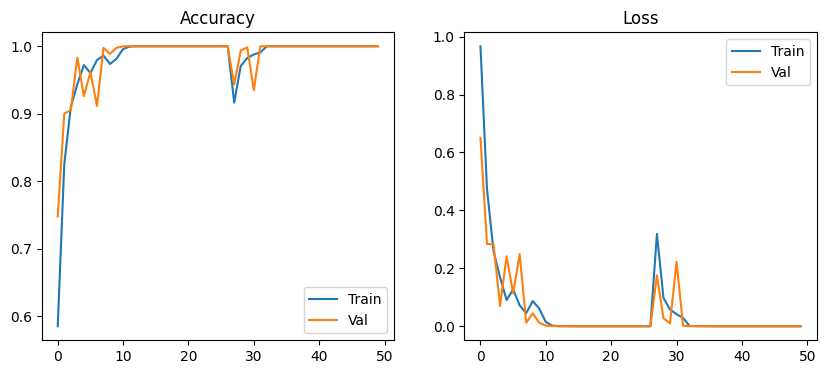

In [27]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Classification Report:
               precision    recall  f1-score   support

        fear       1.00      1.00      1.00      1820
       happy       1.00      1.00      1.00      1600
     neutral       1.00      1.00      1.00      2038
         sad       1.00      1.00      1.00      2057

    accuracy                           1.00      7515
   macro avg       1.00      1.00      1.00      7515
weighted avg       1.00      1.00      1.00      7515



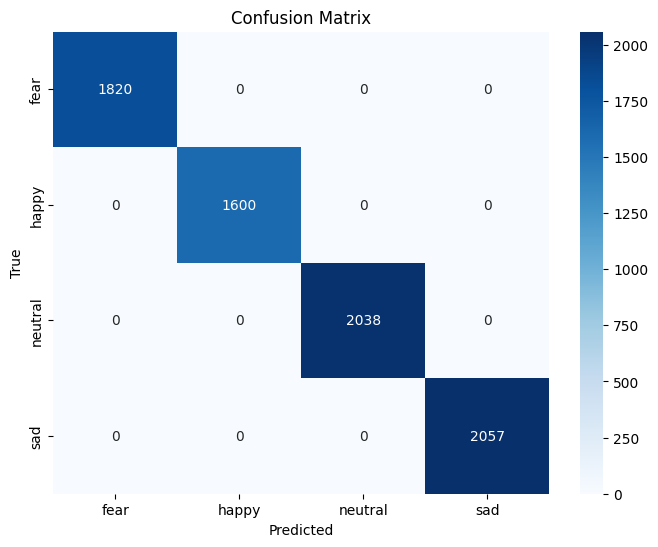

In [28]:

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [37]:
#again new
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_generator(latent_dim, num_classes):
    noise_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(num_classes,))
    merged = Concatenate()([noise_input, label_input])
    x = Dense(128, activation='relu')(merged)
    x = Dense(62 * 5, activation='tanh')(x)
    x = Reshape((62, 5))(x)
    return Model([noise_input, label_input], x)

def build_discriminator(input_shape, num_classes):
    data_input = Input(shape=input_shape)
    label_input = Input(shape=(num_classes,))
    x = Flatten()(data_input)
    merged = Concatenate()([x, label_input])
    x = Dense(128, activation='relu')(merged)
    x = Dense(1, activation='sigmoid')(x)
    return Model([data_input, label_input], x)

# Parameters
latent_dim = 100
num_classes = 4

# 1. Build generator and discriminator
generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator((62, 5), num_classes)

# 2. Compile discriminator BEFORE freezing it
discriminator.compile(optimizer=Adam(0.0001, 0.5), loss='binary_crossentropy')

# 3. Freeze discriminator
discriminator.trainable = False

# 4. Build combined GAN (cGAN)
noise_input = Input(shape=(latent_dim,))
label_input = Input(shape=(num_classes,))
generated_sample = generator([noise_input, label_input])
validity = discriminator([generated_sample, label_input])

cgan = Model([noise_input, label_input], validity)

# 5. Compile the combined model
cgan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')


In [38]:
def train_gan(epochs=5000, batch_size=64):
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_samples = X_train[idx]
        real_labels = y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict([noise, real_labels])

        real_y = np.ones((batch_size, 1))
        fake_y = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch([real_samples, real_labels], real_y)
        d_loss_fake = discriminator.train_on_batch([fake_samples, real_labels], fake_y)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = cgan.train_on_batch([noise, real_labels], real_y)

        if epoch % 500 == 0:
            print(f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")
train_gan(epochs=5000)

Streaming output truncated to the last 5000 lines.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

In [39]:

def generate_synthetic_samples(n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    random_classes = np.random.randint(0, num_classes, n_samples)
    labels_categorical = to_categorical(random_classes, num_classes=num_classes)
    synthetic_data = generator.predict([noise, labels_categorical])
    return synthetic_data, labels_categorical

synthetic_X, synthetic_y = generate_synthetic_samples(10000)

# Combine real + synthetic
X_combined = np.concatenate((X_train, synthetic_X), axis=0)
y_combined = np.concatenate((y_train, synthetic_y), axis=0)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [40]:
from collections import Counter
import numpy as np

# Convert one-hot encoded labels back to integer indices
train_labels = np.argmax(y_combined, axis=1)

# Decode ALL possible class indices to label names (0 to num_classes-1)
# This ensures we have a label name for every possible index generated by the GAN
label_names = le.inverse_transform(np.arange(num_classes))

# Count occurrences
class_counts = Counter(train_labels)

# Display counts with emotion names
for idx in sorted(class_counts.keys()):
    # Check if the index exists in the label_names array before accessing
    if idx < len(label_names):
        print(f"{label_names[idx]}: {class_counts[idx]} samples")
    else:
        # This case shouldn't happen with the fix above, but good for debugging
        print(f"Unknown index {idx}: {class_counts[idx]} samples")

fear: 9912 samples
happy: 8832 samples
neutral: 10609 samples
sad: 10707 samples


In [41]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_combined.shape)
print(y_combined.shape)

(30060, 62, 5)
(30060, 4)
(7515, 62, 5)
(7515, 4)
(40060, 62, 5)
(40060, 4)


In [42]:

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)



model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(62, 5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 emotions
])



model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset
)

Epoch 1/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.4553 - loss: 1.1799 - val_accuracy: 0.7633 - val_loss: 0.6119
Epoch 2/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.7930 - loss: 0.5576 - val_accuracy: 0.8640 - val_loss: 0.3785
Epoch 3/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9127 - loss: 0.2598 - val_accuracy: 0.9250 - val_loss: 0.2195
Epoch 4/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9369 - loss: 0.1930 - val_accuracy: 0.9776 - val_loss: 0.0793
Epoch 5/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9802 - loss: 0.0702 - val_accuracy: 0.9554 - val_loss: 0.1331
Epoch 6/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9755 - loss: 0.0763 - val_accuracy: 0.9718 - val_loss: 0.0911
Epoch 7/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9795 - loss: 0.0646 - val_accuracy: 0.9843 - val_loss: 0.0506
Epoch 8/50
940/940 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9711 - loss: 0.0925 - 

In [52]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 8.3862e-05
Test Accuracy: 100.00%


In [51]:
test_loss, test_acc = model.evaluate(X_train, y_train)
print(f"Test Accuracy: {test_acc*100:.2f}%")


940/940 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 7.7712e-05
Test Accuracy: 100.00%


In [54]:
# Save model
model.save(save_path + "SEED4_eeg_emotion_gan_model.h5")

# Save scaler
with open(save_path + 'SEED4_eeg_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save label encoder
with open(save_path + 'SEED4_eeg_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Model and preprocessors saved to Google Drive.")

Model and preprocessors saved to Google Drive.


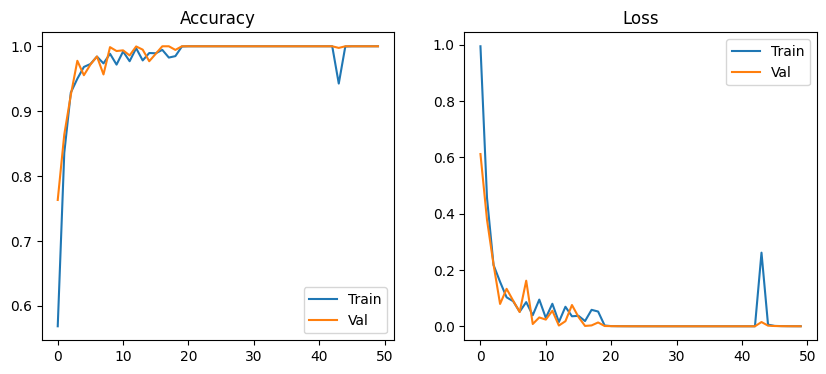

In [53]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Classification Report:
               precision    recall  f1-score   support

        fear       1.00      1.00      1.00      1820
       happy       1.00      1.00      1.00      1600
     neutral       1.00      1.00      1.00      2038
         sad       1.00      1.00      1.00      2057

    accuracy                           1.00      7515
   macro avg       1.00      1.00      1.00      7515
weighted avg       1.00      1.00      1.00      7515



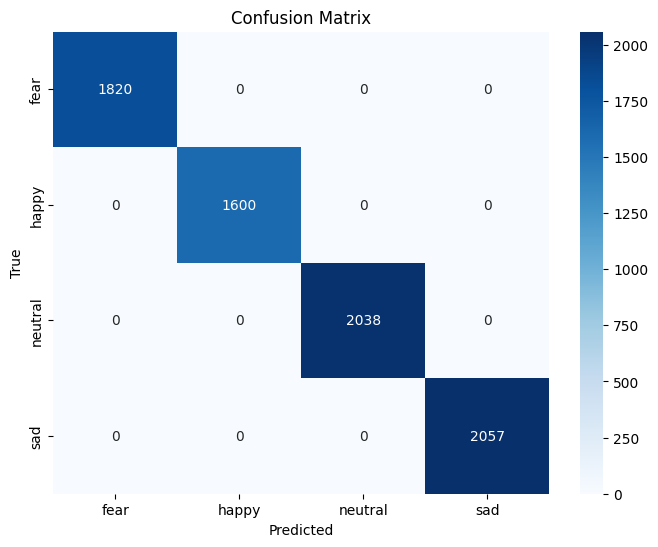

In [55]:

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
